<a href="https://colab.research.google.com/github/JaiswalFelipe/ITNPAI1_Assignment/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INITIAL

In [1]:
import tensorflow as tf
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras import optimizers

# Adjust figure sizes
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100 

In [2]:
# Load data, Train, val, test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

print("Training set size:", X_train.shape)
#print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
Training set size: (45000, 32, 32, 3)
Testing set size: (10000, 32, 32, 3)


# Image samples for each classes

In [3]:
# Creating and populating a dictionary to show random samples of images
class_dict = {"0": [],"1": [],"2": [],"3": [],"4": [],
              "5": [],"6": [],"7": [],"8": [],"9": []}

for i in range(len(X_train)):
  if y_train[i] == 0:
    class_dict["0"].append(X_train[i])
  elif y_train[i] == 1:
    class_dict["1"].append(X_train[i])
  elif y_train[i] == 2:
    class_dict["2"].append(X_train[i])
  elif y_train[i] == 3:
    class_dict["3"].append(X_train[i])
  elif y_train[i] == 4:
    class_dict["4"].append(X_train[i])
  elif y_train[i] == 5:
    class_dict["5"].append(X_train[i]) 
  elif y_train[i] == 6:
    class_dict["6"].append(X_train[i])
  elif y_train[i] == 7:
    class_dict["7"].append(X_train[i])
  elif y_train[i] == 8:
    class_dict["8"].append(X_train[i])
  elif y_train[i] == 9:
    class_dict["9"].append(X_train[i])

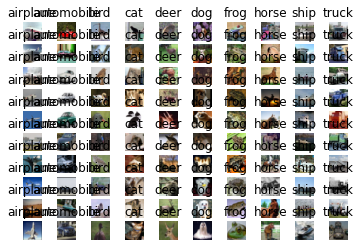

In [4]:
# Create a dict
class_dict_copy = class_dict.copy()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

col = 0

f, axarr = plt.subplots(10,10)

for key in class_dict_copy:
  for i in range(0,10):
    img = random.choice(class_dict_copy[key])
    axarr[col, i].axis("off")
    axarr[col, i].title.set_text(classes[i])
    axarr[i, col].imshow(img)
  col += 1

# Data preparation

In [5]:
#y_train = np_utils.to_categorical(y_train, num_classes = 10)
#y_test = np_utils.to_categorical(y_test, num_classes = 10)
#y_valid = np_utils.to_categorical(y_valid, num_classes = 10)

In [6]:
!pip install d2l==0.16.2 # Uncomment and run this if you are using Google Colab

     |████████████████████████████████| 77 kB 3.9 MB/s 


In [7]:
# VGG16: Reduced parameters, layers, 
import pandas as pd
from keras.layers import BatchNormalization
def VGG16_Brief(classes=10): 
    
    img_input = Input(shape=(32,32,3)) 

    # Conv1
    x = Conv2D(32,(3,3),padding='same',activation = 'relu')(img_input) # 1. Input Tensors
    x = Dropout(0.256)(x)
    #x = Conv2D(32,(3,3),padding='same',activation = 'relu')(x)        # 2
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 1

    # Conv2
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 3
    x = Dropout(0.25)(x)
    #x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x) # 4
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 2
    #x = Dropout(0.25)(x)

    # Conv3  
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x) # 5
    x = Dropout(0.25)(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 6
    #x = Dropout(0.15)(x)
    #x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x) # 7
    #x = Dropout(0.15)(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 3
    #x = Dropout(0.2)(x)

    # Conv4
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 8
   #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 9
   #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 10
    x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 4

    # Conv5
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 11
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 12
    #x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x) # 13
    #x = MaxPooling2D((2,2),strides=(2,2))(x) # maxpool 5

    # FC
    x = Flatten()(x)
    #x = Dense(1024, activation = 'relu')(x) # 14
    #x = Dropout(0.5)(x)
    #x = Dense(4096, activation = 'relu')(x) # 15
    x = Dense(512, activation = 'relu')(x)   # 16
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

model_ep25 = VGG16_Brief(classes = 10)
model_ep25.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                             

### Epoch 25

In [ ]:
model_ep25.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sparse_categorical_crossentropy for loss

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)


history_ep25 = model_ep25.fit(X_train, y_train, epochs=25,
        validation_data=(X_valid, y_valid),callbacks = [learning_rate_reduction],batch_size=256)

Epoch 1/25
176/176 [==============================] - 399s 2s/step - loss: 2.8994 - accuracy: 0.2997 - val_loss: 1.6654 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 2/25
176/176 [==============================] - 382s 2s/step - loss: 1.4728 - accuracy: 0.4632 - val_loss: 1.3835 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 3/25
  9/176 [>.............................] - ETA: 5:57 - loss: 1.3565 - accuracy: 0.5078

In [ ]:
test_loss, test_acc = model_ep25.evaluate(X_test,y_test)
print('test loss:', test_loss)
print('test acc:', test_acc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_ep25.history["accuracy"], 'y', label= 'ACCURACY')
plt.plot(history_ep25.history["val_accuracy"], 'g', label= 'VAL_ACC')

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.subplot(111)
plt.plot(history_ep25.history['loss'], 'r', label= 'LOSS')
plt.plot(history_ep25.history["val_loss"], 'b', label= 'VAL_LOSS')
#plt.plot(test_acc, 'r', label= 'TEST_ACC')
plt.ylabel("LOSS")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.show()

### Epoch 50

### Epoch 75

### SAVE MODEL


# Hyperparameter tuning
# data augmentation?  